# Import and Extract Data

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math
import time
import nltk
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from gensim import models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

In [34]:
# Load in word2vec embeddings

embeds = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
# Load in data as Pandas DataFrame

with open('news_data.csv') as f:
    data = pd.read_csv(f)

data

,text,keywords
0,There Were 2 Mass Shootings In Texas Last Week...,"['mass', 'week', 'shootings', 'texas', 'crime']"
1,Will Smith Joins Diplo And Nicky Jam For The 2...,"['world', 'song', 'smith', 'joins', 'diplo', '..."
2,Hugh Grant Marries For The First Time At Age 57,"['age', 'grant', 'marries', 'time', 'hugh', 'e..."
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"['castrato', 'blasts', 'adam', 'artwork', 'car..."
4,Julianna Margulies Uses Donald Trump Poop Bags...,"['dog', 'margulies', 'donald', 'trump', 'poop'..."
...,...,...
381983,Verizon Wireless and AT&T are already promotin...,"['wireless', 'lte', 'rim', 'verizon', 'rivals'..."
381984,"Afterward, Azarenka, more effusive with the pr...","['azarenka', 'afterward', 'sam', 'sumyk', 'nor..."
381985,"Leading up to Super Bowl XLVI, the most talked...","['xlvi', 'super', 'bowl', 'leading', 'ago', 's..."
381986,CORRECTION: An earlier version of this story i...,"['correction', 'ktvu', 'league', 'sacks', 'ear..."


In [36]:
# Extract text and labels

text = data['text'].tolist()
keywords = data['keywords'].tolist()

# 1. Average Word Embeddings

In [37]:
# Tokenize training sentences

tok_text = []

for sent in text:
    tok_text.append(nltk.word_tokenize(sent))

In [38]:
# Map each word in sentence to GoogleNews embedding and average them

avg_embeds = []
pca_avg_embeds = []
bad_idx = []

for i, sent in enumerate(tok_text):
    word_embed = np.zeros(embeds['the'].shape)
    length = 0
    
    for word in sent:
        try:    # Check if word has a valid embedding
            word_embed += embeds[word]
            length += 1
        except:
            pass
    
    if length == 0:
        bad_idx.append(i)    # Keep track of which indicies have no valid embeddings for its tokens
        length = 1
    
    word_embed = word_embed/length
    pca_avg_embeds.append(word_embed)
    avg_embeds.append(torch.tensor(word_embed))
    

# bad_idx

# 2. Cluster Averaged Embeddings

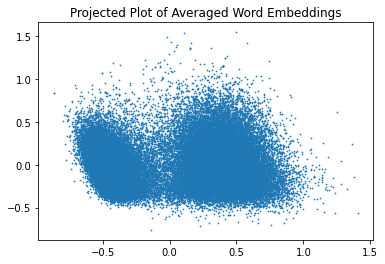

In [41]:
# Perform and visualize PCA for averaged embeddings

random.shuffle(pca_avg_embeds)

coordinates = PCA(n_components=2).fit_transform(pca_avg_embeds[0:math.ceil(len(pca_avg_embeds)/6)])

plt.scatter(coordinates[:, 0], coordinates[:, 1], s=0.5)
plt.title("Projected Plot of Averaged Word Embeddings")
plt.show()

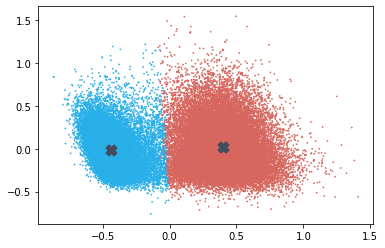

In [42]:
# Perform a K-Means clustering

num_clusters = 2

clf = KMeans(n_clusters=num_clusters, 
            max_iter=200, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(pca_avg_embeds[0:math.ceil(len(pca_avg_embeds)/6)])

pca = PCA(n_components=2).fit(pca_avg_embeds[0:math.ceil(len(pca_avg_embeds)/6)])
coordinates = pca.transform(pca_avg_embeds[0:math.ceil(len(pca_avg_embeds)/6)])

# Plot clusters and centroids
label_colors = ["#2AB0E9", "#D7665E", "#A3DB05"]
colors = [label_colors[i] for i in labels]
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors, s=.5)
centroids = clf.cluster_centers_
centroid_coordinates = pca.transform(centroids)
plt.scatter(centroid_coordinates[:, 0], centroid_coordinates[:, 1], marker='X', s=100, linewidths=2, c='#444d60')
plt.title
plt.show()

# 3. Map Keywords to Embeddings

In [11]:
# Reformat labels from strings to lists.

for i, key in enumerate(keywords):
    keywords[i] = ast.literal_eval(key)

In [12]:
# Make dictionary of all relevant keyword embeddings converted to PyTorch tensors.
# The bad_embeds list was mostly just for my reference.

key_embeds = {}
bad_embeds = []

for keyword in nltk.flatten(keywords):
    if keyword not in key_embeds.keys():
        try:
            key_embeds[keyword] = torch.tensor(embeds[keyword])
        except:
            bad_embeds.append(keyword)

/share/pkg.7/python3/3.7.7/install/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  import sys


# 4. Concatenate Text and Keyword Embeddings

In [13]:
# Compile list of averaged embeddings with a keyword. I did a 50/50 split between keywords with positive
# and negative association to the sentence. 

# I chose to ignore sentences that have only words unknown to the Google News embeddings
# and also didn't include keywords that could not be found in the embeddings.

dataset = []
dataset_labels = []

for i, vec in enumerate(avg_embeds):
    if i not in bad_idx:
        for key in keywords[i]:
            if key in key_embeds.keys():
                
                # Create a concatenated average-vector/label pair for positively associated keywords
                dataset.append(torch.cat((vec, key_embeds[str(key)]), 0))
                dataset_labels.append(1)
                
                # Create a concatenated average-vector/label pair for negatively associated keywords
                neg_key = random.choice(list(key_embeds.keys()))
                
                while neg_key in keywords[i]:    # Check to make sure it doesn't accidently create a positively associated keyword
                    neg_key = random.choice(list(key_embeds.keys()))
                    
                
                dataset.append(torch.cat((vec, key_embeds[str(neg_key)]), 0))
                dataset_labels.append(0)
                
                


# 5. Process with NN

## Architecture 1

In [43]:
# This cell is used for saving/loading in the dataset/dataset labels to avoid re-running the preprocessing 

# Load data and labels

# with open('dataset.p', 'rb') as f:
#     dataset = pickle.load(f)

# with open('dataset_labels.p', 'rb') as d:
#     dataset_labels = pickle.load(d)



# Save data and labels

# pickle.dump(dataset, open("dataset.p", "wb"))
# pickle.dump(dataset_labels, open("dataset_labels.p", "wb"))

In [25]:
# Split into train and test datasets

# Create a 90-10 train/test split
num_train = math.ceil(len(dataset)*0.9) 

# Get indices for shuffled dataset
indices = [i for i in range(len(dataset))]
random.shuffle(indices)
train_idx, test_idx = indices[0:num_train], indices[num_train:]

train_tensors = [dataset[i] for i in train_idx]
test_tensors = [dataset[i] for i in test_idx]

X_train = torch.stack(train_tensors)
X_test = torch.stack(test_tensors)
y_train = torch.tensor([dataset_labels[i] for i in train_idx])
y_test = torch.tensor([dataset_labels[i] for i in test_idx])

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 256

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [26]:
# Define linear NN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(600, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return x

model = Net()
# print(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [27]:
# Define loss function and optimizer and check for GPU.

criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)

device = torch.device(dev) 

cuda:0


In [28]:
# Train the model

losses = []
print_step = 500


for epoch in range(1):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # print statistics
        if i % print_step == 0:
            print('[Epoch %d, step %d] loss: %.3f' %(epoch + 1, i, running_loss / print_step))
            losses.append(running_loss / print_step)
            running_loss = 0.0

print('Finished Training')

[Epoch 1, step 0] loss: 0.001
[Epoch 1, step 500] loss: 0.369
[Epoch 1, step 1000] loss: 0.293
[Epoch 1, step 1500] loss: 0.268
[Epoch 1, step 2000] loss: 0.255
[Epoch 1, step 2500] loss: 0.245
[Epoch 1, step 3000] loss: 0.233
[Epoch 1, step 3500] loss: 0.231
[Epoch 1, step 4000] loss: 0.222
[Epoch 1, step 4500] loss: 0.218
[Epoch 1, step 5000] loss: 0.212
[Epoch 1, step 5500] loss: 0.209
[Epoch 1, step 6000] loss: 0.210
[Epoch 1, step 6500] loss: 0.203
[Epoch 1, step 7000] loss: 0.200
[Epoch 1, step 7500] loss: 0.198
[Epoch 1, step 8000] loss: 0.199
[Epoch 1, step 8500] loss: 0.193
[Epoch 1, step 9000] loss: 0.191
[Epoch 1, step 9500] loss: 0.191
[Epoch 1, step 10000] loss: 0.188
[Epoch 1, step 10500] loss: 0.189
[Epoch 1, step 11000] loss: 0.186
[Epoch 1, step 11500] loss: 0.189
[Epoch 1, step 12000] loss: 0.184
[Epoch 1, step 12500] loss: 0.182
[Epoch 1, step 13000] loss: 0.187
Finished Training


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([157])) that is different to the input size (torch.Size([157, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [31]:
# Define model testing function

def test_model(model, testloader):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs.float())
            outputs = torch.squeeze((outputs >= 0.5)*1)
            correct += ((outputs == labels)*1).sum().item()
            total += labels.size(0)
    
    acc = correct*100/total
    
    print("The test accuracy is", acc, "%")
    
    return acc

test_model(model, test_loader)

The test accuracy is 93.24472680391818 %


93.24472680391818

# Architecture 1 Parameter Search

In [51]:
# Define a similar NN as before but with variable hidden sizes and a dropout layer option

class test_Net(nn.Module):
    def __init__(self, hidden_size1, hidden_size2, dropout):
        super(test_Net, self).__init__()
        self.fc1 = nn.Linear(600, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 100)
        self.fc4 = nn.Linear(100,1)
        self.dropout = nn.Dropout(0.2)
        
        self.use_dropout = dropout
        


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        return x

In [57]:
# Define a function to train a model for use in the parameter search

def train_model(model, train_loader, test_loader):
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
    
    losses = []
    print_step = 500

    for epoch in range(1):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % print_step == 0:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i, running_loss / print_step))
                losses.append(running_loss / print_step)
                running_loss = 0.0

    print('Finished Training')
    
    acc = test_model(model, test_loader)
    
    return acc



In [65]:
# Perform parameter search on 4 folds, average accuracies, and save results in dictionary

n_splits = 4

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
grid = [(128, 500, 250, True), (256, 1000, 500, True), (512, 2000, 1000, True), 
        (128, 500, 250, False), (256, 1000, 500, False), (512, 2000, 1000, False), 
        (128, 2000, 250, False),  (128, 2000, 250, True), (512, 1000, 250, True), 
        (512, 1000, 250, False), (128, 1000, 250, False), (128, 1000, 250, True), 
        (512, 1000, 1000, True), (512, 1000, 1000, False), (128, 2000, 250, False), 
        (512, 500, 1000, True)]

results = {}

test_num = 1

start = time.time()

for params in grid:
    accuracies = []
    for train_idx, test_idx in skf.split(dataset, dataset_labels):
        print("Training on fold %d"%(test_num))
        

        print("params: ", params)
#         print(train_idx, test_idx)

        batch_size = params[0]
        model = test_Net(params[1], params[2], params[3])
        
        
        train_tensors = [dataset[i] for i in train_idx]
        test_tensors = [dataset[i] for i in test_idx]

        X_train = torch.stack(train_tensors)
        X_test = torch.stack(test_tensors)

        y_train = torch.tensor([dataset_labels[i] for i in train_idx])
        y_test = torch.tensor([dataset_labels[i] for i in test_idx])
        
        train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)

        train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
        test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

        accuracies.append(train_model(model, train_loader, test_loader))
    
    
    tot_acc = 0
    for acc in accuracies:
        tot_acc += acc
    tot_acc = tot_acc/n_splits
    
    results[test_num] = {'acc':tot_acc, 'batch_size':params[0], 'hidden_size1':params[1],
                         'hidden_size2':params[2], 'dropout':params[3]}

    test_num += 1
    

end = time.time()

print((end - start)/60)
    


Training on fold 1
params:  (128, 500, 250, True)


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.399
[1,  1000] loss: 0.332
[1,  1500] loss: 0.304
[1,  2000] loss: 0.292
[1,  2500] loss: 0.284
[1,  3000] loss: 0.272
[1,  3500] loss: 0.270
[1,  4000] loss: 0.265
[1,  4500] loss: 0.261
[1,  5000] loss: 0.251
[1,  5500] loss: 0.258
[1,  6000] loss: 0.250
[1,  6500] loss: 0.253
[1,  7000] loss: 0.243
[1,  7500] loss: 0.248
[1,  8000] loss: 0.238
[1,  8500] loss: 0.241
[1,  9000] loss: 0.228
[1,  9500] loss: 0.234
[1, 10000] loss: 0.231
[1, 10500] loss: 0.232
[1, 11000] loss: 0.229
[1, 11500] loss: 0.227
[1, 12000] loss: 0.232
[1, 12500] loss: 0.237
[1, 13000] loss: 0.228
[1, 13500] loss: 0.227
[1, 14000] loss: 0.244
[1, 14500] loss: 0.227
[1, 15000] loss: 0.226
[1, 15500] loss: 0.223
[1, 16000] loss: 0.230
[1, 16500] loss: 0.227
[1, 17000] loss: 0.222
[1, 17500] loss: 0.232
[1, 18000] loss: 0.218
[1, 18500] loss: 0.220
[1, 19000] loss: 0.231
[1, 19500] loss: 0.215
[1, 20000] loss: 0.216
[1, 20500] loss: 0.220
[1, 21000] loss: 0.218
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 91.81510024582983 %
Training on fold 1
params:  (128, 500, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.392
[1,  1000] loss: 0.329
[1,  1500] loss: 0.306
[1,  2000] loss: 0.294
[1,  2500] loss: 0.279
[1,  3000] loss: 0.277
[1,  3500] loss: 0.269
[1,  4000] loss: 0.258
[1,  4500] loss: 0.251
[1,  5000] loss: 0.254
[1,  5500] loss: 0.249
[1,  6000] loss: 0.242
[1,  6500] loss: 0.244
[1,  7000] loss: 0.241
[1,  7500] loss: 0.239
[1,  8000] loss: 0.245
[1,  8500] loss: 0.234
[1,  9000] loss: 0.231
[1,  9500] loss: 0.231
[1, 10000] loss: 0.231
[1, 10500] loss: 0.234
[1, 11000] loss: 0.231
[1, 11500] loss: 0.223
[1, 12000] loss: 0.231
[1, 12500] loss: 0.236
[1, 13000] loss: 0.226
[1, 13500] loss: 0.229
[1, 14000] loss: 0.226
[1, 14500] loss: 0.227
[1, 15000] loss: 0.219
[1, 15500] loss: 0.218
[1, 16000] loss: 0.213
[1, 16500] loss: 0.217
[1, 17000] loss: 0.220
[1, 17500] loss: 0.216
[1, 18000] loss: 0.223
[1, 18500] loss: 0.212
[1, 19000] loss: 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.371
[1,  1000] loss: 0.301
[1,  1500] loss: 0.279
[1,  2000] loss: 0.260
[1,  2500] loss: 0.253
[1,  3000] loss: 0.243
[1,  3500] loss: 0.238
[1,  4000] loss: 0.235
[1,  4500] loss: 0.230
[1,  5000] loss: 0.230
[1,  5500] loss: 0.225
[1,  6000] loss: 0.224
[1,  6500] loss: 0.218
[1,  7000] loss: 0.214
[1,  7500] loss: 0.215
[1,  8000] loss: 0.212
[1,  8500] loss: 0.212
[1,  9000] loss: 0.212
[1,  9500] loss: 0.210
[1, 10000] loss: 0.208
[1, 10500] loss: 0.206
[1, 11000] loss: 0.204


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.14886314338939 %
Training on fold 2
params:  (256, 1000, 500, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.373
[1,  1000] loss: 0.299
[1,  1500] loss: 0.276
[1,  2000] loss: 0.260
[1,  2500] loss: 0.251
[1,  3000] loss: 0.242
[1,  3500] loss: 0.237
[1,  4000] loss: 0.234
[1,  4500] loss: 0.229
[1,  5000] loss: 0.226
[1,  5500] loss: 0.221
[1,  6000] loss: 0.219
[1,  6500] loss: 0.214
[1,  7000] loss: 0.213
[1,  7500] loss: 0.210
[1,  8000] loss: 0.209
[1,  8500] loss: 0.210
[1,  9000] loss: 0.203
[1,  9500] loss: 0.202
[1, 10000] loss: 0.204
[1, 10500] loss: 0.204
[1, 11000] loss: 0.200
Finished Training
The test accuracy is 92.06635278706374 %
Training on fold 2
params:  (256, 1000, 500, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.388
[1,  1000] loss: 0.314
[1,  1500] loss: 0.295
[1,  2000] loss: 0.282
[1,  2500] loss: 0.273
[1,  3000] loss: 0.264
[1,  3500] loss: 0.257
[1,  4000] loss: 0.255
[1,  4500] loss: 0.248
[1,  5000] loss: 0.24

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.411
[1,  1000] loss: 0.326
[1,  1500] loss: 0.308
[1,  2000] loss: 0.298
[1,  2500] loss: 0.292
[1,  3000] loss: 0.284
[1,  3500] loss: 0.278
[1,  4000] loss: 0.271
[1,  4500] loss: 0.267
[1,  5000] loss: 0.265
[1,  5500] loss: 0.262


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 89.59444458621482 %
Training on fold 3
params:  (512, 2000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.447
[1,  1000] loss: 0.263
[1,  1500] loss: 0.243
[1,  2000] loss: 0.234
[1,  2500] loss: 0.222
[1,  3000] loss: 0.220
[1,  3500] loss: 0.207
[1,  4000] loss: 0.205
[1,  4500] loss: 0.204
[1,  5000] loss: 0.203
[1,  5500] loss: 0.197
Finished Training
The test accuracy is 92.59862964758722 %
Training on fold 3
params:  (512, 2000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.375
[1,  1000] loss: 0.288
[1,  1500] loss: 0.268
[1,  2000] loss: 0.254
[1,  2500] loss: 0.248
[1,  3000] loss: 0.240
[1,  3500] loss: 0.235
[1,  4000] loss: 0.229
[1,  4500] loss: 0.223
[1,  5000] loss: 0.219
[1,  5500] loss: 0.218
Finished Training
The test accuracy is 91.50249657624552 %
Training on fold 3
params:  (512, 2000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.351
[1,  1000] loss: 0.261
[1,  1500] loss: 0.235
[1,  2000] loss: 0.220


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.392
[1,  1000] loss: 0.318
[1,  1500] loss: 0.295
[1,  2000] loss: 0.277
[1,  2500] loss: 0.269
[1,  3000] loss: 0.258
[1,  3500] loss: 0.254
[1,  4000] loss: 0.243
[1,  4500] loss: 0.248
[1,  5000] loss: 0.237
[1,  5500] loss: 0.234
[1,  6000] loss: 0.224
[1,  6500] loss: 0.225
[1,  7000] loss: 0.222
[1,  7500] loss: 0.220
[1,  8000] loss: 0.212
[1,  8500] loss: 0.211
[1,  9000] loss: 0.212
[1,  9500] loss: 0.208
[1, 10000] loss: 0.207
[1, 10500] loss: 0.206
[1, 11000] loss: 0.202
[1, 11500] loss: 0.202
[1, 12000] loss: 0.202
[1, 12500] loss: 0.202
[1, 13000] loss: 0.199
[1, 13500] loss: 0.197
[1, 14000] loss: 0.198
[1, 14500] loss: 0.194
[1, 15000] loss: 0.202
[1, 15500] loss: 0.198
[1, 16000] loss: 0.194
[1, 16500] loss: 0.193
[1, 17000] loss: 0.190
[1, 17500] loss: 0.189
[1, 18000] loss: 0.189
[1, 18500] loss: 0.189
[1, 19000] loss: 0.191
[1, 19500] loss: 0.185
[1, 20000] loss: 0.184
[1, 20500] loss: 0.192
[1, 21000] loss: 0.185
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 93.15802009169708 %
Training on fold 4
params:  (128, 500, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.398
[1,  1000] loss: 0.336
[1,  1500] loss: 0.311
[1,  2000] loss: 0.297
[1,  2500] loss: 0.282
[1,  3000] loss: 0.279
[1,  3500] loss: 0.274
[1,  4000] loss: 0.266
[1,  4500] loss: 0.262
[1,  5000] loss: 0.258
[1,  5500] loss: 0.252
[1,  6000] loss: 0.249
[1,  6500] loss: 0.248
[1,  7000] loss: 0.249
[1,  7500] loss: 0.246
[1,  8000] loss: 0.241
[1,  8500] loss: 0.242
[1,  9000] loss: 0.235
[1,  9500] loss: 0.241
[1, 10000] loss: 0.237
[1, 10500] loss: 0.236
[1, 11000] loss: 0.231
[1, 11500] loss: 0.231
[1, 12000] loss: 0.230
[1, 12500] loss: 0.229
[1, 13000] loss: 0.232
[1, 13500] loss: 0.230
[1, 14000] loss: 0.228
[1, 14500] loss: 0.226
[1, 15000] loss: 0.219
[1, 15500] loss: 0.222
[1, 16000] loss: 0.228
[1, 16500] loss: 0.227
[1, 17000] loss: 0.227
[1, 17500] loss: 0.218
[1, 18000] loss: 0.216
[1, 18500] loss: 0.219
[1, 19000] loss:

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.365
[1,  1000] loss: 0.298
[1,  1500] loss: 0.276
[1,  2000] loss: 0.257
[1,  2500] loss: 0.252
[1,  3000] loss: 0.240
[1,  3500] loss: 0.239
[1,  4000] loss: 0.230
[1,  4500] loss: 0.227
[1,  5000] loss: 0.221
[1,  5500] loss: 0.218
[1,  6000] loss: 0.212
[1,  6500] loss: 0.213
[1,  7000] loss: 0.209
[1,  7500] loss: 0.210
[1,  8000] loss: 0.207
[1,  8500] loss: 0.205
[1,  9000] loss: 0.201
[1,  9500] loss: 0.200
[1, 10000] loss: 0.200
[1, 10500] loss: 0.199
[1, 11000] loss: 0.198


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 91.8597579129133 %
Training on fold 5
params:  (256, 1000, 500, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.372
[1,  1000] loss: 0.299
[1,  1500] loss: 0.279
[1,  2000] loss: 0.264
[1,  2500] loss: 0.259
[1,  3000] loss: 0.247
[1,  3500] loss: 0.242
[1,  4000] loss: 0.235
[1,  4500] loss: 0.233
[1,  5000] loss: 0.228
[1,  5500] loss: 0.227
[1,  6000] loss: 0.224
[1,  6500] loss: 0.220
[1,  7000] loss: 0.217
[1,  7500] loss: 0.214
[1,  8000] loss: 0.211
[1,  8500] loss: 0.209
[1,  9000] loss: 0.210
[1,  9500] loss: 0.212
[1, 10000] loss: 0.206
[1, 10500] loss: 0.205
[1, 11000] loss: 0.203
Finished Training
The test accuracy is 92.12462040982979 %
Training on fold 5
params:  (256, 1000, 500, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.374
[1,  1000] loss: 0.295
[1,  1500] loss: 0.271
[1,  2000] loss: 0.259
[1,  2500] loss: 0.251
[1,  3000] loss: 0.244
[1,  3500] loss: 0.234
[1,  4000] loss: 0.229
[1,  4500] loss: 0.230
[1,  5000] loss: 0.2

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.429
[1,  1000] loss: 0.285
[1,  1500] loss: 0.264
[1,  2000] loss: 0.250
[1,  2500] loss: 0.243
[1,  3000] loss: 0.237
[1,  3500] loss: 0.231
[1,  4000] loss: 0.224
[1,  4500] loss: 0.223
[1,  5000] loss: 0.217
[1,  5500] loss: 0.216


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 91.60297632718334 %
Training on fold 6
params:  (512, 2000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.359
[1,  1000] loss: 0.271
[1,  1500] loss: 0.249
[1,  2000] loss: 0.236
[1,  2500] loss: 0.229
[1,  3000] loss: 0.223
[1,  3500] loss: 0.216
[1,  4000] loss: 0.210
[1,  4500] loss: 0.208
[1,  5000] loss: 0.205
[1,  5500] loss: 0.201
Finished Training
The test accuracy is 92.2201027551654 %
Training on fold 6
params:  (512, 2000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 49.906
[1,  1000] loss: 50.043
[1,  1500] loss: 50.139
[1,  2000] loss: 49.930
[1,  2500] loss: 50.035
[1,  3000] loss: 50.071
[1,  3500] loss: 49.992
[1,  4000] loss: 49.992
[1,  4500] loss: 49.834
[1,  5000] loss: 49.959
[1,  5500] loss: 50.013
Finished Training
The test accuracy is 50.0 %
Training on fold 6
params:  (512, 2000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.363
[1,  1000] loss: 0.270
[1,  1500] loss: 0.249
[1,  2000] loss: 0.236


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.394
[1,  1000] loss: 0.319
[1,  1500] loss: 0.298
[1,  2000] loss: 0.280
[1,  2500] loss: 0.268
[1,  3000] loss: 0.259
[1,  3500] loss: 0.250
[1,  4000] loss: 0.245
[1,  4500] loss: 0.242
[1,  5000] loss: 0.240
[1,  5500] loss: 0.236
[1,  6000] loss: 0.232
[1,  6500] loss: 0.224
[1,  7000] loss: 0.227
[1,  7500] loss: 0.223
[1,  8000] loss: 0.215
[1,  8500] loss: 0.221
[1,  9000] loss: 0.216
[1,  9500] loss: 0.219
[1, 10000] loss: 0.211
[1, 10500] loss: 0.212
[1, 11000] loss: 0.201
[1, 11500] loss: 0.214
[1, 12000] loss: 0.208
[1, 12500] loss: 0.203
[1, 13000] loss: 0.208
[1, 13500] loss: 0.215
[1, 14000] loss: 0.202
[1, 14500] loss: 0.197
[1, 15000] loss: 0.195
[1, 15500] loss: 0.196
[1, 16000] loss: 0.193
[1, 16500] loss: 0.198
[1, 17000] loss: 0.194
[1, 17500] loss: 0.197
[1, 18000] loss: 0.190
[1, 18500] loss: 0.196
[1, 19000] loss: 0.197
[1, 19500] loss: 0.191
[1, 20000] loss: 0.186
[1, 20500] loss: 0.198
[1, 21000] loss: 0.189
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 93.03553049055384 %
Training on fold 7
params:  (128, 2000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.393
[1,  1000] loss: 0.323
[1,  1500] loss: 0.297
[1,  2000] loss: 0.285
[1,  2500] loss: 0.278
[1,  3000] loss: 0.263
[1,  3500] loss: 0.249
[1,  4000] loss: 0.255
[1,  4500] loss: 0.244
[1,  5000] loss: 0.239
[1,  5500] loss: 0.231
[1,  6000] loss: 0.230
[1,  6500] loss: 0.238
[1,  7000] loss: 0.228
[1,  7500] loss: 0.224
[1,  8000] loss: 0.217
[1,  8500] loss: 0.212
[1,  9000] loss: 0.213
[1,  9500] loss: 0.211
[1, 10000] loss: 0.212
[1, 10500] loss: 0.204
[1, 11000] loss: 0.207
[1, 11500] loss: 0.203
[1, 12000] loss: 0.195
[1, 12500] loss: 0.197
[1, 13000] loss: 0.198
[1, 13500] loss: 0.197
[1, 14000] loss: 0.197
[1, 14500] loss: 0.196
[1, 15000] loss: 0.195
[1, 15500] loss: 0.203
[1, 16000] loss: 0.198
[1, 16500] loss: 0.194
[1, 17000] loss: 0.200
[1, 17500] loss: 0.189
[1, 18000] loss: 0.189
[1, 18500] loss: 0.188
[1, 19000] loss

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.407
[1,  1000] loss: 0.329
[1,  1500] loss: 0.301
[1,  2000] loss: 0.289
[1,  2500] loss: 0.281
[1,  3000] loss: 0.265
[1,  3500] loss: 0.262
[1,  4000] loss: 0.258
[1,  4500] loss: 0.252
[1,  5000] loss: 0.247
[1,  5500] loss: 0.246
[1,  6000] loss: 0.244
[1,  6500] loss: 0.244
[1,  7000] loss: 0.236
[1,  7500] loss: 0.233
[1,  8000] loss: 0.232
[1,  8500] loss: 0.225
[1,  9000] loss: 0.231
[1,  9500] loss: 0.228
[1, 10000] loss: 0.228
[1, 10500] loss: 0.224
[1, 11000] loss: 0.219
[1, 11500] loss: 0.212
[1, 12000] loss: 0.218
[1, 12500] loss: 0.220
[1, 13000] loss: 0.218
[1, 13500] loss: 0.218
[1, 14000] loss: 0.211
[1, 14500] loss: 0.213
[1, 15000] loss: 0.211
[1, 15500] loss: 0.214
[1, 16000] loss: 0.212
[1, 16500] loss: 0.215
[1, 17000] loss: 0.211
[1, 17500] loss: 0.209
[1, 18000] loss: 0.210
[1, 18500] loss: 0.208
[1, 19000] loss: 0.218
[1, 19500] loss: 0.211
[1, 20000] loss: 0.227
[1, 20500] loss: 0.321
[1, 21000] loss: 0.234
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.36715407320455 %
Training on fold 8
params:  (128, 2000, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.396
[1,  1000] loss: 0.326
[1,  1500] loss: 0.295
[1,  2000] loss: 0.284
[1,  2500] loss: 0.274
[1,  3000] loss: 0.266
[1,  3500] loss: 0.261
[1,  4000] loss: 0.248
[1,  4500] loss: 0.253
[1,  5000] loss: 0.243
[1,  5500] loss: 0.240
[1,  6000] loss: 0.239
[1,  6500] loss: 0.238
[1,  7000] loss: 0.227
[1,  7500] loss: 0.235
[1,  8000] loss: 0.224
[1,  8500] loss: 0.227
[1,  9000] loss: 0.224
[1,  9500] loss: 0.224
[1, 10000] loss: 0.221
[1, 10500] loss: 0.224
[1, 11000] loss: 0.213
[1, 11500] loss: 0.211
[1, 12000] loss: 0.228
[1, 12500] loss: 0.215
[1, 13000] loss: 0.215
[1, 13500] loss: 0.213
[1, 14000] loss: 0.212
[1, 14500] loss: 0.223
[1, 15000] loss: 0.210
[1, 15500] loss: 0.216
[1, 16000] loss: 0.210
[1, 16500] loss: 0.213
[1, 17000] loss: 0.206
[1, 17500] loss: 0.203
[1, 18000] loss: 0.207
[1, 18500] loss: 0.198
[1, 19000] loss:

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.330
[1,  1000] loss: 0.259
[1,  1500] loss: 0.238
[1,  2000] loss: 0.225
[1,  2500] loss: 0.217
[1,  3000] loss: 0.209
[1,  3500] loss: 0.206
[1,  4000] loss: 0.199
[1,  4500] loss: 0.195
[1,  5000] loss: 0.192
[1,  5500] loss: 0.189


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.67911977611622 %
Training on fold 9
params:  (512, 1000, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.351
[1,  1000] loss: 0.282
[1,  1500] loss: 0.263
[1,  2000] loss: 0.249
[1,  2500] loss: 0.241
[1,  3000] loss: 0.235
[1,  3500] loss: 0.230
[1,  4000] loss: 0.225
[1,  4500] loss: 0.219
[1,  5000] loss: 0.216
[1,  5500] loss: 0.215
Finished Training
The test accuracy is 91.61935080511394 %
Training on fold 9
params:  (512, 1000, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.343
[1,  1000] loss: 0.269
[1,  1500] loss: 0.251
[1,  2000] loss: 0.237
[1,  2500] loss: 0.230
[1,  3000] loss: 0.223
[1,  3500] loss: 0.216
[1,  4000] loss: 0.213
[1,  4500] loss: 0.210
[1,  5000] loss: 0.206
[1,  5500] loss: 0.202
Finished Training
The test accuracy is 92.15173399341619 %
Training on fold 9
params:  (512, 1000, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.340
[1,  1000] loss: 0.269
[1,  1500] loss: 0.244
[1,  2000] loss: 0.227
[1,

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.335
[1,  1000] loss: 0.262
[1,  1500] loss: 0.244
[1,  2000] loss: 0.229
[1,  2500] loss: 0.223
[1,  3000] loss: 0.214
[1,  3500] loss: 0.207
[1,  4000] loss: 0.205
[1,  4500] loss: 0.201
[1,  5000] loss: 0.197
[1,  5500] loss: 0.194


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.60671055877374 %
Training on fold 10
params:  (512, 1000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.320
[1,  1000] loss: 0.245
[1,  1500] loss: 0.225
[1,  2000] loss: 0.211
[1,  2500] loss: 0.201
[1,  3000] loss: 0.196
[1,  3500] loss: 0.188
[1,  4000] loss: 0.183
[1,  4500] loss: 0.181
[1,  5000] loss: 0.176
[1,  5500] loss: 0.175
Finished Training
The test accuracy is 93.34526331011135 %
Training on fold 10
params:  (512, 1000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.341
[1,  1000] loss: 0.269
[1,  1500] loss: 0.248
[1,  2000] loss: 0.234
[1,  2500] loss: 0.226
[1,  3000] loss: 0.216
[1,  3500] loss: 0.212
[1,  4000] loss: 0.208
[1,  4500] loss: 0.203
[1,  5000] loss: 0.200
[1,  5500] loss: 0.198
Finished Training
The test accuracy is 92.36555915652299 %
Training on fold 10
params:  (512, 1000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.337
[1,  1000] loss: 0.266
[1,  1500] loss: 0.241
[1,  2000] loss: 0.2

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.400
[1,  1000] loss: 0.327
[1,  1500] loss: 0.308
[1,  2000] loss: 0.286
[1,  2500] loss: 0.277
[1,  3000] loss: 0.267
[1,  3500] loss: 0.268
[1,  4000] loss: 0.251
[1,  4500] loss: 0.256
[1,  5000] loss: 0.244
[1,  5500] loss: 0.245
[1,  6000] loss: 0.244
[1,  6500] loss: 0.243
[1,  7000] loss: 0.233
[1,  7500] loss: 0.235
[1,  8000] loss: 0.231
[1,  8500] loss: 0.231
[1,  9000] loss: 0.227
[1,  9500] loss: 0.225
[1, 10000] loss: 0.219
[1, 10500] loss: 0.220
[1, 11000] loss: 0.219
[1, 11500] loss: 0.218
[1, 12000] loss: 0.217
[1, 12500] loss: 0.217
[1, 13000] loss: 0.214
[1, 13500] loss: 0.212
[1, 14000] loss: 0.212
[1, 14500] loss: 0.213
[1, 15000] loss: 0.207
[1, 15500] loss: 0.210
[1, 16000] loss: 0.207
[1, 16500] loss: 0.211
[1, 17000] loss: 0.208
[1, 17500] loss: 0.209
[1, 18000] loss: 0.199
[1, 18500] loss: 0.209
[1, 19000] loss: 0.200
[1, 19500] loss: 0.204
[1, 20000] loss: 0.205
[1, 20500] loss: 0.207
[1, 21000] loss: 0.204
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 91.80606238463436 %
Training on fold 11
params:  (128, 1000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.392
[1,  1000] loss: 0.318
[1,  1500] loss: 0.294
[1,  2000] loss: 0.277
[1,  2500] loss: 0.265
[1,  3000] loss: 0.258
[1,  3500] loss: 0.249
[1,  4000] loss: 0.239
[1,  4500] loss: 0.232
[1,  5000] loss: 0.235
[1,  5500] loss: 0.227
[1,  6000] loss: 0.225
[1,  6500] loss: 0.221
[1,  7000] loss: 0.225
[1,  7500] loss: 0.214
[1,  8000] loss: 0.213
[1,  8500] loss: 0.211
[1,  9000] loss: 0.210
[1,  9500] loss: 0.211
[1, 10000] loss: 0.205
[1, 10500] loss: 0.206
[1, 11000] loss: 0.208
[1, 11500] loss: 0.200
[1, 12000] loss: 0.200
[1, 12500] loss: 0.200
[1, 13000] loss: 0.194
[1, 13500] loss: 0.198
[1, 14000] loss: 0.193
[1, 14500] loss: 0.192
[1, 15000] loss: 0.194
[1, 15500] loss: 0.190
[1, 16000] loss: 0.191
[1, 16500] loss: 0.189
[1, 17000] loss: 0.184
[1, 17500] loss: 0.186
[1, 18000] loss: 0.190
[1, 18500] loss: 0.194
[1, 19000] los

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.391
[1,  1000] loss: 0.321
[1,  1500] loss: 0.298
[1,  2000] loss: 0.290
[1,  2500] loss: 0.276
[1,  3000] loss: 0.267
[1,  3500] loss: 0.259
[1,  4000] loss: 0.252
[1,  4500] loss: 0.249
[1,  5000] loss: 0.247
[1,  5500] loss: 0.244
[1,  6000] loss: 0.237
[1,  6500] loss: 0.240
[1,  7000] loss: 0.234
[1,  7500] loss: 0.234
[1,  8000] loss: 0.238
[1,  8500] loss: 0.232
[1,  9000] loss: 0.231
[1,  9500] loss: 0.229
[1, 10000] loss: 0.226
[1, 10500] loss: 0.222
[1, 11000] loss: 0.213
[1, 11500] loss: 0.220
[1, 12000] loss: 0.221
[1, 12500] loss: 0.218
[1, 13000] loss: 0.227
[1, 13500] loss: 0.219
[1, 14000] loss: 0.221
[1, 14500] loss: 0.215
[1, 15000] loss: 0.212
[1, 15500] loss: 0.226
[1, 16000] loss: 0.220
[1, 16500] loss: 0.217
[1, 17000] loss: 0.211
[1, 17500] loss: 0.206
[1, 18000] loss: 0.207
[1, 18500] loss: 0.215
[1, 19000] loss: 0.208
[1, 19500] loss: 0.210
[1, 20000] loss: 0.198
[1, 20500] loss: 0.207
[1, 21000] loss: 0.207
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.32111414499707 %
Training on fold 12
params:  (128, 1000, 250, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.394
[1,  1000] loss: 0.324
[1,  1500] loss: 0.306
[1,  2000] loss: 0.293
[1,  2500] loss: 0.278
[1,  3000] loss: 0.268
[1,  3500] loss: 0.265
[1,  4000] loss: 0.265
[1,  4500] loss: 0.253
[1,  5000] loss: 0.250
[1,  5500] loss: 0.249
[1,  6000] loss: 0.250
[1,  6500] loss: 0.239
[1,  7000] loss: 0.239
[1,  7500] loss: 0.238
[1,  8000] loss: 0.233
[1,  8500] loss: 0.227
[1,  9000] loss: 0.234
[1,  9500] loss: 0.237
[1, 10000] loss: 0.227
[1, 10500] loss: 0.227
[1, 11000] loss: 0.231
[1, 11500] loss: 0.221
[1, 12000] loss: 0.223
[1, 12500] loss: 0.220
[1, 13000] loss: 0.217
[1, 13500] loss: 0.216
[1, 14000] loss: 0.216
[1, 14500] loss: 0.215
[1, 15000] loss: 0.218
[1, 15500] loss: 0.215
[1, 16000] loss: 0.210
[1, 16500] loss: 0.212
[1, 17000] loss: 0.210
[1, 17500] loss: 0.215
[1, 18000] loss: 0.216
[1, 18500] loss: 0.208
[1, 19000] loss

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.395
[1,  1000] loss: 0.316
[1,  1500] loss: 0.295
[1,  2000] loss: 0.280
[1,  2500] loss: 0.272
[1,  3000] loss: 0.264
[1,  3500] loss: 0.259
[1,  4000] loss: 0.253
[1,  4500] loss: 0.249
[1,  5000] loss: 0.246
[1,  5500] loss: 0.243


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 89.36498923962878 %
Training on fold 13
params:  (512, 1000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.367
[1,  1000] loss: 0.282
[1,  1500] loss: 0.256
[1,  2000] loss: 0.243
[1,  2500] loss: 0.236
[1,  3000] loss: 0.228
[1,  3500] loss: 0.225
[1,  4000] loss: 0.221
[1,  4500] loss: 0.216
[1,  5000] loss: 0.214
[1,  5500] loss: 0.213
Finished Training
The test accuracy is 91.80606238463436 %
Training on fold 13
params:  (512, 1000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.408
[1,  1000] loss: 0.321
[1,  1500] loss: 0.309
[1,  2000] loss: 0.303
[1,  2500] loss: 0.298
[1,  3000] loss: 0.296
[1,  3500] loss: 0.295
[1,  4000] loss: 0.289
[1,  4500] loss: 0.286
[1,  5000] loss: 0.289
[1,  5500] loss: 0.286
Finished Training
The test accuracy is 88.44195779212494 %
Training on fold 13
params:  (512, 1000, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.378
[1,  1000] loss: 0.307
[1,  1500] loss: 0.285
[1,  2000] loss: 0.2

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.477
[1,  1000] loss: 0.295
[1,  1500] loss: 0.275
[1,  2000] loss: 0.260
[1,  2500] loss: 0.253
[1,  3000] loss: 0.245
[1,  3500] loss: 0.241
[1,  4000] loss: 0.234
[1,  4500] loss: 0.232
[1,  5000] loss: 0.228
[1,  5500] loss: 0.224


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 91.10961543368974 %
Training on fold 14
params:  (512, 1000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.359
[1,  1000] loss: 0.279
[1,  1500] loss: 0.254
[1,  2000] loss: 0.243
[1,  2500] loss: 0.234
[1,  3000] loss: 0.227
[1,  3500] loss: 0.223
[1,  4000] loss: 0.219
[1,  4500] loss: 0.215
[1,  5000] loss: 0.215
[1,  5500] loss: 0.211
Finished Training
The test accuracy is 91.77341975655192 %
Training on fold 14
params:  (512, 1000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.489
[1,  1000] loss: 0.289
[1,  1500] loss: 0.274
[1,  2000] loss: 0.260
[1,  2500] loss: 0.252
[1,  3000] loss: 0.248
[1,  3500] loss: 0.246
[1,  4000] loss: 0.242
[1,  4500] loss: 0.241
[1,  5000] loss: 0.237
[1,  5500] loss: 0.235
Finished Training
The test accuracy is 90.37659172684819 %
Training on fold 14
params:  (512, 1000, 1000, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.369
[1,  1000] loss: 0.281
[1,  1500] loss: 0.260
[1,  2000] loss: 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.402
[1,  1000] loss: 0.324
[1,  1500] loss: 0.301
[1,  2000] loss: 0.286
[1,  2500] loss: 0.279
[1,  3000] loss: 0.266
[1,  3500] loss: 0.262
[1,  4000] loss: 0.257
[1,  4500] loss: 0.251
[1,  5000] loss: 0.246
[1,  5500] loss: 0.240
[1,  6000] loss: 0.236
[1,  6500] loss: 0.235
[1,  7000] loss: 0.233
[1,  7500] loss: 0.227
[1,  8000] loss: 0.223
[1,  8500] loss: 0.227
[1,  9000] loss: 0.222
[1,  9500] loss: 0.220
[1, 10000] loss: 0.217
[1, 10500] loss: 0.216
[1, 11000] loss: 0.217
[1, 11500] loss: 0.210
[1, 12000] loss: 0.210
[1, 12500] loss: 0.208
[1, 13000] loss: 0.208
[1, 13500] loss: 0.212
[1, 14000] loss: 0.205
[1, 14500] loss: 0.206
[1, 15000] loss: 0.206
[1, 15500] loss: 0.202
[1, 16000] loss: 0.206
[1, 16500] loss: 0.218
[1, 17000] loss: 0.212
[1, 17500] loss: 0.199
[1, 18000] loss: 0.199
[1, 18500] loss: 0.198
[1, 19000] loss: 0.201
[1, 19500] loss: 0.200
[1, 20000] loss: 0.200
[1, 20500] loss: 0.192
[1, 21000] loss: 0.189
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 92.66657309822135 %
Training on fold 15
params:  (128, 2000, 250, False)
[1,     0] loss: 0.001
[1,   500] loss: 0.416
[1,  1000] loss: 0.316
[1,  1500] loss: 0.290
[1,  2000] loss: 0.275
[1,  2500] loss: 0.265
[1,  3000] loss: 0.251
[1,  3500] loss: 0.247
[1,  4000] loss: 0.241
[1,  4500] loss: 0.239
[1,  5000] loss: 0.233
[1,  5500] loss: 0.229
[1,  6000] loss: 0.230
[1,  6500] loss: 0.220
[1,  7000] loss: 0.218
[1,  7500] loss: 0.215
[1,  8000] loss: 0.207
[1,  8500] loss: 0.208
[1,  9000] loss: 0.210
[1,  9500] loss: 0.206
[1, 10000] loss: 0.202
[1, 10500] loss: 0.205
[1, 11000] loss: 0.201
[1, 11500] loss: 0.198
[1, 12000] loss: 0.198
[1, 12500] loss: 0.191
[1, 13000] loss: 0.189
[1, 13500] loss: 0.196
[1, 14000] loss: 0.194
[1, 14500] loss: 0.194
[1, 15000] loss: 0.193
[1, 15500] loss: 0.193
[1, 16000] loss: 0.204
[1, 16500] loss: 0.188
[1, 17000] loss: 0.190
[1, 17500] loss: 0.191
[1, 18000] loss: 0.184
[1, 18500] loss: 0.185
[1, 19000] los

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.354
[1,  1000] loss: 0.286
[1,  1500] loss: 0.267
[1,  2000] loss: 0.256
[1,  2500] loss: 0.250
[1,  3000] loss: 0.244
[1,  3500] loss: 0.242
[1,  4000] loss: 0.237
[1,  4500] loss: 0.235
[1,  5000] loss: 0.232
[1,  5500] loss: 0.230


/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([344])) that is different to the input size (torch.Size([344, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 90.54607820620784 %
Training on fold 16
params:  (512, 500, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.371
[1,  1000] loss: 0.308
[1,  1500] loss: 0.290
[1,  2000] loss: 0.280
[1,  2500] loss: 0.271
[1,  3000] loss: 0.264
[1,  3500] loss: 0.260
[1,  4000] loss: 0.252
[1,  4500] loss: 0.253
[1,  5000] loss: 0.249
[1,  5500] loss: 0.248
Finished Training
The test accuracy is 90.20338377523159 %
Training on fold 16
params:  (512, 500, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.373
[1,  1000] loss: 0.297
[1,  1500] loss: 0.276
[1,  2000] loss: 0.266
[1,  2500] loss: 0.259
[1,  3000] loss: 0.251
[1,  3500] loss: 0.244
[1,  4000] loss: 0.240
[1,  4500] loss: 0.240
[1,  5000] loss: 0.240
[1,  5500] loss: 0.239
Finished Training
The test accuracy is 90.80828250865508 %
Training on fold 16
params:  (512, 500, 1000, True)
[1,     0] loss: 0.001
[1,   500] loss: 0.350
[1,  1000] loss: 0.275
[1,  1500] loss: 0.255
[1,  2000] loss: 0.242


In [66]:
results

{1: {'acc': 91.97217295701806,
  'batch_size': 128,
  'hidden_size1': 500,
  'hidden_size2': 250,
  'dropout': True},
 2: {'acc': 91.91095473839114,
  'batch_size': 256,
  'hidden_size1': 1000,
  'hidden_size2': 500,
  'dropout': True},
 3: {'acc': 91.6623072277371,
  'batch_size': 512,
  'hidden_size1': 2000,
  'hidden_size2': 1000,
  'dropout': True},
 4: {'acc': 92.54084049982562,
  'batch_size': 128,
  'hidden_size1': 500,
  'hidden_size2': 250,
  'dropout': False},
 5: {'acc': 92.1848550965031,
  'batch_size': 256,
  'hidden_size1': 1000,
  'hidden_size2': 500,
  'dropout': False},
 6: {'acc': 81.48506413691615,
  'batch_size': 512,
  'hidden_size1': 2000,
  'hidden_size2': 1000,
  'dropout': False},
 7: {'acc': 92.96328076487951,
  'batch_size': 128,
  'hidden_size1': 2000,
  'hidden_size2': 250,
  'dropout': False},
 8: {'acc': 92.28504244604929,
  'batch_size': 128,
  'hidden_size1': 2000,
  'hidden_size2': 250,
  'dropout': True},
 9: {'acc': 92.29833341839556,
  'batch_size':

# Retrain Full Model with Best Parameters

In [70]:
# Split into train and test datasets

num_train = math.ceil(len(dataset)*0.9)

indices = [i for i in range(len(dataset))]
random.shuffle(indices)

train_idx, test_idx = indices[0:num_train], indices[num_train:]

train_tensors = [dataset[i] for i in train_idx]
test_tensors = [dataset[i] for i in test_idx]

X_train = torch.stack(train_tensors)
X_test = torch.stack(test_tensors)

y_train = torch.tensor([dataset_labels[i] for i in train_idx])
y_test = torch.tensor([dataset_labels[i] for i in test_idx])

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 128

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

best_model = test_Net(2000, 250, False)

In [71]:
train_model(best_model, train_loader, test_loader)

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     0] loss: 0.001
[1,   500] loss: 0.398
[1,  1000] loss: 0.315
[1,  1500] loss: 0.292
[1,  2000] loss: 0.276
[1,  2500] loss: 0.264
[1,  3000] loss: 0.258
[1,  3500] loss: 0.245
[1,  4000] loss: 0.242
[1,  4500] loss: 0.237
[1,  5000] loss: 0.231
[1,  5500] loss: 0.226
[1,  6000] loss: 0.232
[1,  6500] loss: 0.220
[1,  7000] loss: 0.216
[1,  7500] loss: 0.217
[1,  8000] loss: 0.211
[1,  8500] loss: 0.211
[1,  9000] loss: 0.207
[1,  9500] loss: 0.208
[1, 10000] loss: 0.203
[1, 10500] loss: 0.200
[1, 11000] loss: 0.197
[1, 11500] loss: 0.200
[1, 12000] loss: 0.196
[1, 12500] loss: 0.193
[1, 13000] loss: 0.201
[1, 13500] loss: 0.196
[1, 14000] loss: 0.192
[1, 14500] loss: 0.192
[1, 15000] loss: 0.186
[1, 15500] loss: 0.189
[1, 16000] loss: 0.187
[1, 16500] loss: 0.181
[1, 17000] loss: 0.184
[1, 17500] loss: 0.182
[1, 18000] loss: 0.186
[1, 18500] loss: 0.182
[1, 19000] loss: 0.183
[1, 19500] loss: 0.187
[1, 20000] loss: 0.181
[1, 20500] loss: 0.178
[1, 21000] loss: 0.177
[1, 21500] 

/share/pkg.7/pytorch/1.6.0/install/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Finished Training
The test accuracy is 93.15328486556174 %


93.15328486556174